<H1>Challenge: Build Three Logistic Regression Classifiers</H1><br><br>
I'm revisiting this loan data to complete this excercise. I'm going to build three logistic regressions: a "vanilla" logreg, a ridge, and lasso.

I tinker excessively with parameters to find the best performers by a number of different metrics. Then, I train my models on this set and test them on future loans (from 2012-13).

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import e
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from cleaning_funcs import treat_loan_data
%matplotlib inline

sns.set_style('whitegrid')

df = pd.read_csv(
    'LoanStats3a_securev1.csv',
    skipinitialspace=True,
    header=1
)

df = df[:-2] #Drop last two "summary" rows
df = df[:39786:] #Drop another summary row

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
can_use = [] #These are the features that lenders can see for loans on the market.

can_use += [     
    'issue_d',
    'loan_amnt',            
    'sub_grade',            
    'int_rate',
    'fico_range_low',
    'term',
    'installment',
    'home_ownership',
    'emp_title', 
    'emp_length',
    'zip_code', 
    'addr_state', 
    'verification_status', 
    'application_type', 
    'annual_inc',
    'annual_inc_joint',
    'dti',
    'dti_joint',
    'earliest_cr_line',
    'open_acc',
    'total_acc',
    'revol_bal',
    'revol_util',
    'inq_last_6mths',
    'acc_now_delinq',
    'delinq_amnt',
    'delinq_2yrs',
    'mths_since_last_delinq',
    'pub_rec',
    'mths_since_last_record',
    'collections_12_mths_ex_med'    
]

loans = df[can_use + ['loan_status']].copy()    #Drop the columns we don't need.

<H2>Data Preparation</H2>

Let the cleaning begin.

<H3>Input Variables</H3><br>
I'll start by converting the input variables to numeric/usable types. I wrote the cleaning script called <a href='https://github.com/AlliedToasters/LendingClubGrade/blob/master/cleaning_funcs.py'>cleaning_funcs.py</a> to accomplish this.

In [96]:
loans = treat_loan_data(loans, 2011) #See cleaning_funcs.py for details

/home/alliedtoasters/thinkful/loans4/cleaning_funcs.py:214: RuntimeWarning: divide by zero encountered in log
  loans['log_used_cred'] = np.where(loans.used_cred_bal < 1, 0, np.log(loans.used_cred_bal)) #log of used cred bal


<H3>Binary Outcome: "Good" or "Bad" Loans</H3>

<br>I'll break the "loan status" variable into two groups: "good," which are the loans that pay on time or early, and "bad," which are late by any amount of time (from one day late to default/charged off).

In [97]:
good_statuses = ['Current', 'Fully Paid']
loans['is_good'] = np.where((loans.loan_status.isin(good_statuses)), 1, 0)

<H2>Grabbing Data and Holdout Group</H2><br>
To evaluate model performance, I'll shuffle the rows in the data frame and reserve half for training, the second half for testing.

In [98]:
fts = [                     #Pick my favorite features.
    'issue_d',
    'loan_amnt',            
    'sub_grade',
    'fico_range_low',
    'term_type',
    'installment',
    'home_ownership',
    'emp_length',
    'verification_status',
    'log_inc_joint',
    'dti_joint',
    'fcl_before_loan',
    'open_acc',
    'total_acc',
    'log_used_cred',
    'inq_last_6mths',
    'delinq_2yrs',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'log_cf'
]

loans = loans.sample(frac=1, random_state=3)   #shuffle rows
cutoff = int(len(loans)/2)

train = loans[:cutoff]

X_train = train[fts]
Y_train = train['is_good']

X_test = loans[fts][cutoff:]
Y_test = loans['is_good'][cutoff:]

In [99]:
X_train = scale(X_train)
X_test = scale(X_test)

<H2>Logistic Regression Models<H2>
<H3>Model 1: "Vanilla" Logistic Regression</H3><br>
This data suffers from a class weight imbalance. Almost 86% of the loans are in the "good loan" class. We can modify performance by varying the "false" outcome weight parameter of our classic logistic regression model.

In [100]:
from sklearn.metrics import roc_curve, roc_auc_score

#Test 'vanilla' model over a range of class weight parameters
param = []
tn = []
fn = []
fp = []
tp = []
acc = []
auc_sc = []
coeff = []

for val in range(1, 160):
    prm = val/4
    param.append(prm)
    vlr = LogisticRegression(C=1e7, class_weight={0:prm, 1:1})
    vlr_fit = vlr.fit(X_train, Y_train)
    Y_ = vlr_fit.predict(X_test)
    coeff.append(vlr_fit.coef_)
    tab = pd.crosstab(Y_, Y_test)
    probs = vlr.predict_proba(X_test)[:, 1]
    auc_sc.append(roc_auc_score(Y_test, probs))
    if len(tab) == 1:
        fp.append(tab.iloc[0,0])
        tp.append(tab.iloc[0,1])
        fn.append(0)
        tn.append(0)
        acc.append(len(Y_test[Y_test==1])/(len(Y_test)))
    else:
        tn.append(tab.iloc[0,0])
        fn.append(tab.iloc[0,1])
        fp.append(tab.iloc[1,0])
        tp.append(tab.iloc[1,1])
        acc.append((tab.iloc[0,0]+tab.iloc[1,1])/tab.sum().sum())

plt.show();
result1 = pd.DataFrame()
result1['weight'] = param
result1['tn'] = tn
result1['fn'] = fn
result1['fp'] = fp
result1['tp'] = tp
result1['accuracy'] = acc
result1['auc roc score'] = auc_sc
result1['negatives_identified'] = result1.tn/(result1.tn+result1.fp)
result1['positives_identified'] = result1.tp/(result1.tp+result1.fn)
result1['precision'] = result1.tp/(result1.tp + result1.fp)
result1['loans recommended'] = (result1.tp+result1.fp) / len(X_test)
result1['coefficients'] = coeff

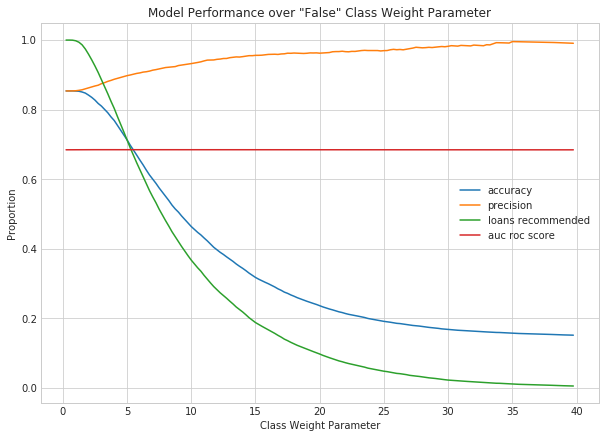

In [101]:
#Visualize results. 
fig = plt.figure(figsize=(10, 7))
for ft in ['accuracy', 'precision', 'loans recommended', 'auc roc score']:
    plt.plot(result1.weight, result1[ft], label=ft);

plt.legend(loc=5);
plt.xlabel('Class Weight Parameter');
plt.ylabel('Proportion');
plt.title('Model Performance over "False" Class Weight Parameter');

<H3>Results Interpretation</H3><br>
It turns out that varying the minority class weight parameter is almost exactly equivalent to changing the class selection probability threshold, as evidenced by the flat auc rc score curve.<br><br>
When we add the coefficient penalties, I'll set the weight class to 'balanced'.

In [102]:
#The most accurate results are those that recommend almost all of the loans.
result1.loc[result1.accuracy.sort_values(ascending=False).index].head()

,weight,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,loans recommended,coefficients
2,0.75,3,2,2906,16982,0.853818,0.684689,0.001031,0.999882,0.853882,0.999749,"[[-0.0191583161637, -0.209461580223, 0.1972410..."
0,0.25,0,0,2909,16984,0.853768,0.684575,0.000000,1.000000,0.853768,1.000000,"[[-0.0150073223423, -0.21418093018, 0.19214427..."
1,0.50,0,0,2909,16984,0.853768,0.684639,0.000000,1.000000,0.853768,1.000000,"[[-0.0172462131739, -0.211527595942, 0.1948369..."
3,1.00,16,23,2893,16961,0.853416,0.684729,0.005500,0.998646,0.854286,0.998040,"[[-0.0208789289612, -0.207661162698, 0.1993340..."
4,1.25,52,70,2857,16914,0.852863,0.684762,0.017876,0.995878,0.855495,0.993867,"[[-0.0224143143442, -0.206053248665, 0.2012728..."


In [103]:
#auc roc score does vary slightly. The max value falls very close to the value which balances the classes.
result1.loc[result1['auc roc score'].sort_values(ascending=False).index].head()

,weight,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,loans recommended,coefficients
20,5.25,1532,4638,1377,12346,0.697632,0.684881,0.526641,0.726919,0.899658,0.689841,"[[-0.0367174553208, -0.192543004824, 0.2190390..."
18,4.75,1376,3882,1533,13102,0.727794,0.684880,0.473015,0.771432,0.895251,0.735686,"[[-0.035508369044, -0.193553445465, 0.21758103..."
19,5.00,1459,4255,1450,12729,0.713216,0.684880,0.501547,0.749470,0.897736,0.712763,"[[-0.0361234493723, -0.193037542394, 0.2183259..."
17,4.50,1288,3520,1621,13464,0.741567,0.684876,0.442764,0.792746,0.892542,0.758307,"[[-0.0348669039184, -0.194106992557, 0.2167972..."
21,5.50,1606,4991,1303,11993,0.683607,0.684876,0.552080,0.706135,0.902001,0.668376,"[[-0.0372856571606, -0.192072961739, 0.2197232..."


In [104]:
#Because we've scaled all of the features in X, we can compare the importance of coefficients by their
#magnitude. Some are clearly more important than others.
result1.loc[result1['auc roc score'].sort_values(ascending=False).index[0]].coefficients

array([[-0.03671746, -0.192543  ,  0.21903905,  0.33807144, -0.2773186 ,
         0.02840169,  0.00322833, -0.02897831,  0.01049201,  0.40796849,
        -0.07849884, -0.0697065 ,  0.03530583, -0.02616694,  0.00912667,
        -0.17070807, -0.02365274, -0.09701899,  0.10244734, -0.1558351 ]])

<H3>Model 2: Ridge Logistic Regression</H3><br>
The ridge regression model offers us another parameter to modify. In the sklearn module, the coefficient limitation penalty is the inverse of the C parameter. We can vary both the class weight and the C coefficient to see if the ridge regression offers any improvement in performance over the "vanilla" model.

In [105]:
#Vary both C and class weight parameters and record results.
C_param = []
weight_ = []
tn = []
fn = []
fp = []
tp = []
acc = []
auc_sc = []
coeff = []

for val in range(1, 80):
    r_ = -val/5
    prm = e**(r_)
    C_param.append(prm)
    vlr = LogisticRegression(penalty='l2', C=prm, class_weight='balanced')
    vlr_fit = vlr.fit(X_train, Y_train)
    coeff.append(vlr_fit.coef_)
    Y_ = vlr_fit.predict(X_test)
    probs = vlr_fit.predict_proba(X_test)[:, 1]
    auc_sc.append(roc_auc_score(Y_test, probs))
    tab = pd.crosstab(Y_, Y_test)
    if len(tab) == 1:
        fp.append(tab.iloc[0,0])
        tp.append(tab.iloc[0,1])
        fn.append(0)
        tn.append(0)
        acc.append(len(Y_test[Y_test==1])/(len(Y_test)))
    else:
        tn.append(tab.iloc[0,0])
        fn.append(tab.iloc[0,1])
        fp.append(tab.iloc[1,0])
        tp.append(tab.iloc[1,1])
        acc.append((tab.iloc[0,0]+tab.iloc[1,1])/tab.sum().sum())

result2 = pd.DataFrame()
result2['log_C'] = np.log(C_param)
result2['tn'] = tn
result2['fn'] = fn
result2['fp'] = fp
result2['tp'] = tp
result2['accuracy'] = acc
result2['auc roc score'] = auc_sc
result2['negatives_identified'] = result2.tn/(result2.tn+result2.fp)
result2['positives_identified'] = result2.tp/(result2.tp+result2.fn)
result2['precision'] = result2.tp/(result2.tp + result2.fp)
result2['predicted_positives'] = (result2.tp+result2.fp) / len(X_test)
result2['coefficients'] = coeff

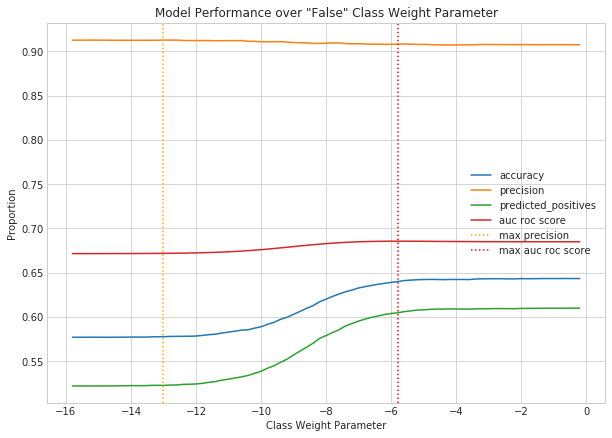

In [131]:
#Visualize results. 
fig = plt.figure(figsize=(10, 7))
for ft in ['accuracy', 'precision', 'predicted_positives', 'auc roc score']:
    plt.plot(result2.log_C, result2[ft], label=ft);

plt.axvline(result2.loc[result2.precision.idxmax()].log_C, linestyle='dotted', c='orange', label='max precision');
plt.axvline(result2.loc[result2['auc roc score'].idxmax()].log_C, linestyle='dotted', c='r', label='max auc roc score');
plt.legend(loc=5);
plt.xlabel('Class Weight Parameter');
plt.ylabel('Proportion');
plt.title('Model Performance over "False" Class Weight Parameter');

<H3>Results Interpretation</H3><br>
Interestingly, as we increase the coefficient size penalty, the auc roc score descreases slightly while precision increases.

In [107]:
#Maximum precision has slightly lower auc roc score
result2.loc[result2.precision.sort_values(ascending=False).index].head()

,log_C,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,predicted_positives,coefficients
64,-13.0,2002,7495,907,9489,0.577640,0.671806,0.688209,0.558702,0.912755,0.522596,"[[0.000557682449557, -0.00179280184941, 0.0062..."
62,-12.6,2001,7486,908,9498,0.578043,0.671962,0.687865,0.559232,0.912743,0.523099,"[[0.000812779277784, -0.00263177733497, 0.0092..."
75,-15.2,2003,7507,906,9477,0.577087,0.671511,0.688553,0.557996,0.912742,0.521942,"[[6.44993862901e-05, -0.000204693198956, 0.000..."
63,-12.8,2001,7488,908,9496,0.577942,0.671875,0.687865,0.559114,0.912726,0.522998,"[[0.000674016245426, -0.0021738137162, 0.00761..."
78,-15.8,2002,7507,907,9477,0.577037,0.671495,0.688209,0.557996,0.912654,0.521993,"[[3.5484391997e-05, -0.000112531472767, 0.0003..."


In [108]:
#Maximum auc roc score occurs at smaller lambda
result2.loc[result2['auc roc score'].sort_values(ascending=False).index].head()

,log_C,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,predicted_positives,coefficients
28,-5.8,1805,6060,1104,10924,0.639873,0.685554,0.620488,0.643194,0.908214,0.604635,"[[-0.0247818159995, -0.116217605981, 0.2480001..."
27,-5.6,1804,6035,1105,10949,0.641080,0.685548,0.620144,0.644666,0.908329,0.605942,"[[-0.0265962087399, -0.122439884949, 0.2457241..."
29,-6.0,1804,6076,1105,10908,0.639019,0.685531,0.620144,0.642252,0.908016,0.603881,"[[-0.0228286210347, -0.110044899757, 0.2498818..."
26,-5.4,1800,6022,1109,10962,0.641532,0.685513,0.618769,0.645431,0.908127,0.606796,"[[-0.0282546964865, -0.128629707483, 0.2432550..."
30,-6.2,1805,6098,1104,10886,0.637963,0.685485,0.620488,0.640956,0.907923,0.602725,"[[-0.0207507947712, -0.103962316395, 0.2511872..."


In [109]:
#where the maximum auc roc score occurs, there are still some more dominant coefficients.
result2.loc[result2['auc roc score'].idxmax()].coefficients

array([[-0.02478182, -0.11621761,  0.24800014,  0.2646114 , -0.26090457,
        -0.01103363,  0.00382926, -0.0227614 ,  0.00753466,  0.31288475,
        -0.02731994, -0.05030426,  0.03028659, -0.00699987, -0.00080769,
        -0.15877488, -0.02233146, -0.07185289,  0.09867012, -0.03823534]])

In [110]:
#We can see that the magnitude of the coefficients has been "smoothed out" by the maximum precision function.
result2.loc[result2.precision.idxmax()].coefficients

array([[ 0.00055768, -0.0017928 ,  0.00627372,  0.00431651, -0.00468814,
        -0.00095858,  0.00039579, -0.00014353, -0.00074124,  0.00214553,
        -0.00116615,  0.00073736,  0.00039555,  0.0008209 , -0.000721  ,
        -0.0022683 , -0.00080055,  0.00087427,  0.00178762,  0.00141287]])

We see some modest improvements over the vanilla model by varying the coefficient size penalty. At the 97% performance threshold, we get over 10% of the loans to choose from. Best accuracy improved negligibly.

<H3>Model 3: Lasso Logistic Regression</H3><br>
As with ridge regression, the lasso l1 penalty has a weight parameter that scales inversely with the sklearn C value. Let's vary the same parameters in the same way as before, only changing the penalty function to the p=1 "l1" norm.

In [111]:
#Vary both C and class weight parameters and record results.
C_param = []
weight_ = []
tn = []
fn = []
fp = []
tp = []
acc = []
auc_sc = []
coeff = []
lost_coef = []
nc = []
num_coef = 0

for val in range(1, 50):
    r_ = -val/5
    prm = e**(r_)
    C_param.append(prm)
    vlr = LogisticRegression(penalty='l1', C=prm, class_weight='balanced')
    vlr_fit = vlr.fit(X_train, Y_train)
    coeff.append(vlr_fit.coef_)
    Y_ = vlr_fit.predict(X_test)
    probs = vlr_fit.predict_proba(X_test)[:, 1]
    auc_sc.append(roc_auc_score(Y_test, probs))
    tab = pd.crosstab(Y_, Y_test)
    if len(tab) == 1:
        fp.append(tab.iloc[0,0])
        tp.append(tab.iloc[0,1])
        fn.append(0)
        tn.append(0)
        acc.append(len(Y_test[Y_test==1])/(len(Y_test)))
    else:
        tn.append(tab.iloc[0,0])
        fn.append(tab.iloc[0,1])
        fp.append(tab.iloc[1,0])
        tp.append(tab.iloc[1,1])
        acc.append((tab.iloc[0,0]+tab.iloc[1,1])/tab.sum().sum())
    n = 0
    for coef in list(vlr_fit.coef_[0]):
        #print(coef)
        if coef != 0:
            n += 1
    nc.append(n)
    if num_coef != n:
        if val == 1:
            lost_coef.append(0)
            num_coef = n
        else:
            lost_coef.append(1)
            num_coef = n
    else:
        lost_coef.append(0)
        


result3 = pd.DataFrame()
result3['log_C'] = np.log(C_param)
result3['tn'] = tn
result3['fn'] = fn
result3['fp'] = fp
result3['tp'] = tp
result3['accuracy'] = acc
result3['auc roc score'] = auc_sc
result3['negatives_identified'] = result3.tn/(result3.tn+result3.fp)
result3['positives_identified'] = result3.tp/(result3.tp+result3.fn)
result3['precision'] = result3.tp/(result3.tp + result3.fp)
result3['predicted positives'] = (result3.tp+result3.fp) / len(X_test)
result3['coefficients'] = coeff
result3['number of nonzero coefficients'] = nc
result3['n coefficients as fraction of n features'] = nc/result3['number of nonzero coefficients'].max()
result3['coefficient collapse threshold'] = lost_coef

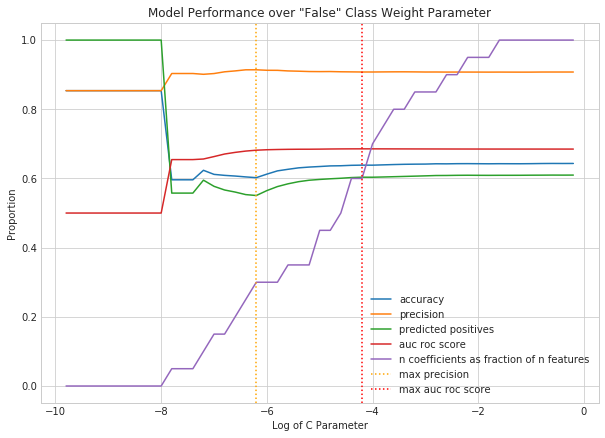

In [126]:
#Visualize results. 
fig = plt.figure(figsize=(10, 7))
for ft in ['accuracy', 'precision', 'predicted positives', 'auc roc score', 'n coefficients as fraction of n features']:
    plt.plot(result3.log_C, result3[ft], label=ft);
    
plt.axvline(result3.loc[result3.precision.idxmax()].log_C, linestyle='dotted', c='orange', label='max precision');
plt.axvline(result3.loc[result3['auc roc score'].idxmax()].log_C, linestyle='dotted', c='r', label='max auc roc score');
plt.legend(loc=4);
plt.xlabel('Log of C Parameter');
plt.ylabel('Proportion');
plt.title('Model Performance over "False" Class Weight Parameter');

<H3>Results Interpretation</H3><br>
The lasso regression is distinctly "rougher" than the ridge regression over a changing lambda parameter. The spikes occur as coefficients shrink to zero with the increasing regularization parameter.<br><br>
This is a type of automated feature selection, where the smallest features go away as the parameter increases. We see here that, while the auc roc score sees very little improvement, the precision has a global maximum with many coefficients removed.

In [113]:
#The maximum precision here is higher than in ridge regression by a small amount.
result3.loc[result3.precision.sort_values(ascending=False).index].head()

,log_C,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,predicted positives,coefficients,number of nonzero coefficients,n coefficients as fraction of n features,coefficient collapse threshold
30,-6.2,1968,6971,941,10013,0.602272,0.681642,0.676521,0.589555,0.914095,0.550646,"[[0.0, 0.0, 0.354078712853, 0.0375026216753, -...",6,0.30,0
31,-6.4,1963,6923,946,10061,0.604434,0.679108,0.674802,0.592381,0.914055,0.553310,"[[0.0, 0.0, 0.360088689588, 0.0126486057759, -...",5,0.25,1
29,-6.0,1928,6728,981,10256,0.612477,0.682995,0.662771,0.603862,0.912699,0.564872,"[[0.0, 0.0, 0.350824218554, 0.0599737970013, -...",6,0.30,0
28,-5.8,1906,6519,1003,10465,0.621877,0.683691,0.655208,0.616168,0.912539,0.576484,"[[0.0, 0.0, 0.348172108922, 0.0789043743013, -...",6,0.30,1
32,-6.6,1915,6825,994,10159,0.606947,0.675350,0.658302,0.598151,0.910876,0.560649,"[[0.0, 0.0, 0.351633411609, 0.0, -0.0944924095...",4,0.20,1


In [130]:
#We can see the surviving coefficients at the maximum precision point
result3.loc[result3.precision.idxmax()].coefficients

array([[ 0.        ,  0.        ,  0.35407871,  0.03750262, -0.14395765,
         0.        ,  0.        ,  0.        ,  0.        ,  0.1432878 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0543752 ,  0.        ,  0.        ,  0.01706483,  0.        ]])

In [115]:
#Overall best auc roc score is very very slightly higher than ridge regression
result3.loc[result3['auc roc score'].sort_values(ascending=False).index].head()

,log_C,tn,fn,fp,tp,accuracy,auc roc score,negatives_identified,positives_identified,precision,predicted positives,coefficients,number of nonzero coefficients,n coefficients as fraction of n features,coefficient collapse threshold
20,-4.2,1801,6084,1108,10900,0.638466,0.685592,0.619113,0.641780,0.907728,0.603629,"[[-0.00904143721875, -0.118852179935, 0.259591...",12,0.60,1
19,-4.0,1801,6086,1108,10898,0.638365,0.685570,0.619113,0.641663,0.907713,0.603529,"[[-0.0148476591871, -0.126649346312, 0.2513806...",14,0.70,1
21,-4.4,1807,6100,1102,10884,0.637963,0.685528,0.621176,0.640838,0.908059,0.602524,"[[-0.00211759368527, -0.110123790735, 0.268544...",12,0.60,0
18,-3.8,1803,6070,1106,10914,0.639270,0.685505,0.619801,0.642605,0.907987,0.604233,"[[-0.0194490185153, -0.133480826853, 0.2441665...",15,0.75,1
17,-3.6,1804,6053,1105,10931,0.640175,0.685427,0.620144,0.643606,0.908192,0.605037,"[[-0.0228283581466, -0.139168684579, 0.2384744...",16,0.80,0


In [116]:
# A number of coefficients are rejected before to achieve the maximum auc roc score.
result3.loc[result3['auc roc score'].idxmax()].coefficients

array([[-0.00904144, -0.11885218,  0.25959127,  0.25215114, -0.25587179,
         0.        ,  0.        , -0.01076028,  0.        ,  0.30364302,
         0.        , -0.03768017,  0.00616862,  0.        ,  0.        ,
        -0.15501398,  0.        , -0.046051  ,  0.09317235,  0.        ]])

The lasso regression did better than the ridge regression by a slight margin.<br>
<H2>Try It</H2><br>
I'd like to test this model on a different data set. I'll use the optimum parameters and train with all of the data. I make three models: the 100% performance model, the 97% performance model, and the maximum accuracy model.

I think the best performer in "real life" would be something more in the middle:

In [117]:
X = loans[fts]
Y = loans['is_good']

max_auc = LogisticRegression(penalty='l1', C=e**(-4.2), class_weight='balanced')
max_auc = max_auc.fit(X, Y)  #The model with highest auc

max_prec = LogisticRegression(penalty='l1', C=e**(-6.2), class_weight='balanced')
max_prec = max_prec.fit(X, Y) #The model with highest precision

no_pen = LogisticRegression(C=1e7, class_weight={0:5, 1:1})
no_pen = no_pen.fit(X, Y) #The best performing model without coefficient penalty

ridge_ = LogisticRegression(penalty='l2', C=e**(-5.8), class_weight='balanced')
ridge_ = ridge_.fit(X, Y)  #The ridge regression model with max auc

In [118]:
df = pd.read_csv(
    'LoanStats3b_securev1.csv',          #Load up 2012-2013 loans
    skipinitialspace=True,
    header=1
)

loans2 = df[can_use + ['loan_status']]
loans2 = loans2[:-2]             #remove null rows

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,49,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [119]:
loans2 = treat_loan_data(loans2, 2013)

/home/alliedtoasters/thinkful/loans4/cleaning_funcs.py:214: RuntimeWarning: divide by zero encountered in log
  loans['log_used_cred'] = np.where(loans.used_cred_bal < 1, 0, np.log(loans.used_cred_bal)) #log of used cred bal


In [120]:
loans2['is_good'] = np.where((loans2.loan_status.isin(good_statuses)), 1, 0)
Y_13 = loans2.is_good
X_13 = loans2[fts]
X_13 = scale(X_13)

In [121]:
print('class imbalance (precision to beat): ', loans2.is_good.sum()/len(loans2))

class imbalance (precision to beat):  0.842720572215


In [122]:
Y_50_ = max_auc.predict(X_13)
tb = pd.crosstab(Y_50_, Y_13)
print('max auc model predictions at p=.5 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

Y_probs = max_auc.predict_proba(X_13)[:,1]
Y_60_ = np.where(Y_probs>.60, 1, 0)

tb = pd.crosstab(Y_60_, Y_13)
print('\nmax auc model predictions at p=.6 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

max auc model predictions at p=.5 threshold:
is_good      0       1
row_0                 
0        14807   48723
1        14790  109861
precision:  0.881348725642

max auc model predictions at p=.6 threshold:
is_good      0       1
row_0                 
0        27630  137860
1         1967   20724
precision:  0.913313648583


In [123]:
Y_13_ = max_prec.predict(X_13)
tb = pd.crosstab(Y_13_, Y_13)
print('\nmax precision model predictions at p=.5 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

Y_probs = max_prec.predict_proba(X_13)[:,1]
Y_60_ = np.where(Y_probs>.60, 1, 0)

tb = pd.crosstab(Y_60_, Y_13)
print('\nmax precision model predictions at p=.6 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))


max precision model predictions at p=.5 threshold:
is_good      0      1
row_0                
0        17333  63499
1        12264  95085
precision:  0.88575580583

max precision model predictions at p=.6 threshold:
is_good      0       1
row_0                 
0        29597  158583
1            0       1
precision:  1.0


In [124]:
Y_13_ = ridge_.predict(X_13)
tb = pd.crosstab(Y_13_, Y_13)
print('ridge regression model at p=.5 threshold')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

Y_probs = ridge_.predict_proba(X_13)[:,1]
Y_60_ = np.where(Y_probs>.60, 1, 0)

tb = pd.crosstab(Y_60_, Y_13)
print('\nridge regression model at p=.6 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

ridge regression model at p=.5 threshold
is_good      0      1
row_0                
0        18557  66025
1        11040  92559
precision:  0.893435264819

ridge regression model at p=.6 threshold:
is_good      0       1
row_0                 
0        29596  158574
1            1      10
precision:  0.909090909091


In [125]:
Y_13_ = no_pen.predict(X_13)
tb = pd.crosstab(Y_13_, Y_13)
print('penalty-free model at p=.5 threshold')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

Y_probs = no_pen.predict_proba(X_13)[:,1]
Y_60_ = np.where(Y_probs>.60, 1, 0)

tb = pd.crosstab(Y_60_, Y_13)
print('\npenalty-free model predictions at p=.6 threshold:')
print(tb)
print('precision: ', tb.iloc[1,1]/(tb.iloc[1,1]+tb.iloc[1,0]))

penalty-free model at p=.5 threshold
is_good      0      1
row_0                
0        19289  65225
1        10308  93359
precision:  0.900566236121

penalty-free model predictions at p=.6 threshold:
is_good      0       1
row_0                 
0        29597  158583
1            0       1
precision:  1.0


While all three models are able to improve on a random selection strategy, only the maximum auc model is able to provide a meaningful number of predictions at the p=.7 threshold.<br><br>
Notie that the precision of the regularization-free model performs the best at the p=.5 threshold, with a precision close to 90%.

<H2>Conclusion</H2>

Before testing the models on the future data, the ridge model with maximum auc appeared to be the top performer. With the future data set predictions, the highest auc ridge model actually performed better. However, at the p=.6 threshold, the lasso regression model offered a usable number of positive predictions with a precision above 90%, while all the other models did not provide a meaningful number of positive predictions.
<br><br>
The highest precision of predictions came from the lasso regression with a stricter (p=.6) decision threshold, but at the p=.5 threshold, the ridge regression performed better.
This shows that both algorithms have strengths and weaknesses. To improve this model further, we can look at the features that the lasso regression keeps and improve them. Possibly a combination (elastic net) model could help us gain benefits from both types of regularization.